In [148]:
# 
import pandas as pd
import numpy as np
import json
import os
import gensim
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 
from gensim.models.doc2vec import Doc2Vec
from tqdm import tqdm
from IPython.display import Image

A bit of background:
The Federal Communication Commissions' public comment period on its plans to repeal net neutrality protections was bombarded with bots, memes, and input from people who do not actually exist. The situation has gotten so bad that FCC Commissioner Jessica Rosenworcel, as well as several members of Congress, including one Republican, have called for the FCC to postpone its December 14 net neutrality vote so that an investigation can take place.

How many of those commenters are real? How many are bots? How many were real, but using identical form letters drafted by advocacy groups?

As a workaround, the FCC has decided to ignore the majority of comments submitted by the public in favor of lengthy legal arguments submitted by interest groups and corporations. In doing so, it undermines the only real tool the public has to express their opinions about the rules that govern them. It's silencing their voices more than a million bots ever could.

__How does one even create unique fake comments en mass?__

Possibly with the help of WordPress comment generator or other review generator tools which are often used in ecommerce to create fake unique reviews to boost sales or improve websearch placing

## Combining the 3 json folder to one csv file

The whole data is contained in 3 folders each containing ~740 json files. 
Combined the data set contains more than 22 million comments and is ~70GB large.

In [ ]:
# loading one json to inspect its contents and the data structure

json_f = pd.read_json('/Users/johannesjanousek/Documents/DataSets/fcc_comments_data/ECFS_17-108_1/ecfs_17-108_10000.json')
json_f.head(1)

__Data Dictonary__

        addressentity:
        This column includes two address lines, city name, state and zip code of the commentators' place of residency.
        
        confirmation_number:
        Unique comment number with the first 6 numbers representing the date of publication(different from the date received and date submission)
        
        date_submission:
        Time and date of comment submission to the FCC.
        
        date_received:
        Time and date of the comment received by the FCC. Is equal to date_submission.
        
        date_disseminated:
        Time and date of publication of comment on FCC website. This time and date is later in the year than date_submission/date_received
        
        filers:
        First and last name of person filing the comment.
        
        highlight:
        The FCC "topic" the comment is adressing. Here, it is "The FCC's Open Internet Rules (net neutrality)"
        
        id_submission:
        unique comment submission id
        
        proceedings:
        
        submissiontype:
        CO standas for submission in form of a comment
        
        text_data:
        This is the actual comment text. It is supposed to be a unique message to the FCC expressing the commentators view of approval or disproval of the FCC's open internet rules. The text data will be used for analysis.
        
        viewingstatus:
        If the comment has "unrestricted" viewing status it is publicly visible.

In [ ]:
# Iterate through the folders and then append the text_data to DataFrame
# This was done through an amazon web server as my local machine does not have enough memory

path_1 = '/Users/johannesjanousek/Documents/DataSets/fcc_comments_data/ECFS_17-108_1/'
path_2 = '/Users/johannesjanousek/Documents/DataSets/fcc_comments_data/ECFS_17-108_2/'
path_3 = '/Users/johannesjanousek/Documents/DataSets/fcc_comments_data/ECFS_17-108_3/'

fcc_complete_1 = pd.DataFrame()
fcc_complete_2 = pd.DataFrame()
fcc_complete_3 = pd.DataFrame()

for fcc_file in tqdm(os.listdir(path_2)):
    df = pd.read_json(path_2+fcc_file)
    fcc_complete_2 = fcc_complete_2.append(df[['text_data']], ignore_index=True)

In [ ]:
# concat the 3 frames and save as csv
DF = pd.concat([fcc_complete_1, fcc_complete_2, fcc_complete_3])
DF.to_csv('complete_data_set.csv')


__I counted all duplicates and added a column called dupelicate count showing how many times this exact comment was submitted to the FCC. A lot of these are templates submitted by 3rd party organisations who compile citizens' "signatures" online and then submit the comments in bulk. It is difficult to say how many of those have actually been signed by real people and how many were just resubmitted. However, since it is not possible to verify the duplicates I will focus my analysis on the unique 2,955,186 comments.__

In [ ]:
# I counted and removed the duplicates only leaving a column for the dupe count next to the comment
data_by_dupl = pd.read_csv('./data_by_duplicates.csv', index_col=0)
data_by_dupl.head()

In [ ]:
data_by_dupl.shape

In [ ]:
# drop null values
data_by_dupl.dropna(inplace=True)
data_by_dupl.shape

# Assigning comments to cluster by regex strings

__Now i want to manually filter some of the largest bot created samples by using strings and a bot dictionary with regex__

In [ ]:
signature_strings_list = \
[
    ["he FCC\'s Open Internet Rules (net neutrality rules) are extremely important to me","he FCC Open Internet Rules (net neutrality rules) are extremely important to me"],
    ["fight For Our Future as if our life depend on it!", "fight for our future as if our life depend on it!"],
    ["I strongly oppose Chairman Pai&apos;s proposal to reverse net neutrality protections","strongly oppose Chairman Pai's proposal to reverse net neutrality protections","strongly oppose Chairman Pais proposal to reverse net neutrality protections"],
    [" \n\nI'm urging FCC Chairman Ajit Pai to preserve real Net Neutrality rules and keep Title II in place for broadband internet access."],
    ["The Obama-era FCC regulations known as Title II enable the federal government to exert an extraordinary and unnecessary amount of regulatory control over the internet. This bureaucratic overreach impedes innovation, stifles investment and continues to create economic uncertainty for one of the largest sectors of the U.S. economy.\n \nI support Chairman Pai's proposal to roll back Title II and restore the sensible regulatory framework that enjoyed broad bipartisan consensus and enabled the internet to thrive for more than two decades.\n \nI strongly urge all of the FCC Commissioners"],
    ["Net neutrality is a vital principle in a democratic society. The biggest losers under Chairman Pai's proposal are independent news outlets, small businesses, start-up blogs, grassroots activist groups...and everyone who uses the internet. And we won't stay quiet while mega-corporations gain control over the information we consume every day.\n\n\n\nChairman Pai's pay-to-play model would give giant internet companies the power to prioritize"],
    ["Net Neutrality is not negotiable. It's essential to everything we need in our society and democracy - from educational and economic opportunities to political organizing and dissent. \nMillions of people fought for over a decade to secure lasting Net Neutrality protections."],
    ["I support strong net neutrality backed by Title II oversight of ISPs.\n\nI demand that the FCC keep the internet filed as a Title II communications service.\n\nISPs killing competition and damaging internet-based companies does happen, Ajit Pai."],
    ["I am in favor of strong net neutrality under Title II of the Telecommunications Act.\n\n\nSincerely,\n"],
    ["IÕm concerned about ISPs being allowed to discriminate against certain types of data or websites because ISPs could have too much power to determine what I can do online. ThatÕs not the kind of Internet we want to pass on to future generations of technology users."],
    ["I am in favor of strong net neutrality under Title II of the Telecommunications Act.\n\n\nSincerely,\n"],
    ["Make it clear you are Opposed to Docket No."],
    ["We need net neutralityto continue. A free and open internet is the single greatest technology of our time"],
    ["In the past 10 years, broadband companies have been guilty of: deliberately throttling internet traffic, squeezing customers with arbitrary data caps, misleading consumers about the meaning of"],
]

In [ ]:
signature_strings_list_2 = \
[
    ["he FCC\'s Open Internet Rules (net neutrality rules) are extremely important to me","he FCC Open Internet Rules (net neutrality rules) are extremely important to me"],
    ["As an Internet user, I\'m asking the FCC to protect the net neutrality protections currently in place. \n\nThe FCC should throw out Chairman Ajit Pai\'s proposal to give the ISP monopolies like Comcast, AT&T, and Verizon the authority to create Internet fast lanes, stripping Internet users of the meaningful access and privacy protections we fought for and just recently won."],
    ["I am in favor of strong net neutrality under Title II of the Telecommunications Act.\n\n\nSincerely,\n"],
    ["Dear FCC Chairman Ajit Pai,\n\nI support the existing Net Neutrality rules, which classify internet service providers under the Title II provision of the Telecommunications Act. Please DO NOT roll back these regulations.\n\nSincerely,"],
    ["Dear Express Restoring Internet Freedom,"],
    ["As an Etsy seller, net neutrality is essential to the success of my business and my ability to care for myself and my family."],
    ["Net neutrality is shit because without it our ISPs will spy on us!"],
    ["To whom it may concern:\nI would like my video comment at the following URL to be considered for the record.\n\nhttp://video.battleforthenet.com/player/#"],
    ["Net neutrality is a vital principle in a democratic society. The biggest losers under Chairman Pai's proposal are independent news outlets, small businesses, start-up blogs, grassroots activist groups...and everyone who uses the internet. And we won't stay quiet while mega-corporations gain control over the information we consume every day."],
    ["I am in favor of strong net neutrality under Title II of the Telecommunications Act. Sincerely,"],
    ['The Obama-era FCC regulations known as "Title II" enable the federal government to exert an extraordinary and unnecessary amount of regulatory control over the internet. This bureaucratic overreach impedes innovation, stifles investment and continues to create economic uncertainty for one of the largest sectors of the U.S. economy.\n \n I support Chairman Pai\'s proposal to roll back Title II and restore the sensible regulatory framework that enjoyed broad bipartisan consensus and enabled the internet to thrive for more than two decades.\n \n I strongly urge all of the FCC Commissioners to support the Chairman\'s proposal to repeal the harmful Title II internet takeover.'],
    ["Cable and phone companies provide access to the internet. They're telecommunications carriers. They do not (and should not) have the right to censor or slow down my speech and my access to online content."],
    ["The FCC's job is to stand up for consumers, not big cable companies."]
]

In [ ]:
# After trying all different strings, signature_strings_list_3 catches the most bot generated comments
signature_strings_list_3 = \
[
    ["he FCC\'s Open Internet Rules (net neutrality rules) are extremely important to me","he FCC Open Internet Rules (net neutrality rules) are extremely important to me"],
    ["As an Internet user, I\'m asking the FCC to protect the net neutrality protections currently in place. \n\nThe FCC should throw out Chairman Ajit Pai\'s proposal to give the ISP monopolies like Comcast, AT&T, and Verizon the authority to create Internet fast lanes, stripping Internet users of the meaningful access and privacy protections we fought for and just recently won."],
    ["I am in favor of strong net neutrality under Title II of the Telecommunications Act.\n\n\nSincerely,\n"],
    ["Dear FCC Chairman Ajit Pai,\n\nI support the existing Net Neutrality rules, which classify internet service providers under the Title II provision of the Telecommunications Act. Please DO NOT roll back these regulations.\n\nSincerely,"],
    ["Dear Express Restoring Internet Freedom,"],
    ["As an Etsy seller, net neutrality is essential to the success of my business and my ability to care for myself and my family."],
    ["\n\nI'm urging FCC Chairman Ajit Pai to preserve real Net Neutrality rules and keep Title II in place for broadband internet access."],
    ["To whom it may concern:\nI would like my video comment at the following URL to be considered for the record.\n\nhttp://video.battleforthenet.com/player/#"],
    ["Net neutrality is a vital principle in a democratic society. The biggest losers under Chairman Pai's proposal are independent news outlets, small businesses, start-up blogs, grassroots activist groups...and everyone who uses the internet. And we won't stay quiet while mega-corporations gain control over the information we consume every day."],
    ["I strongly oppose Chairman Pai&apos;s proposal to reverse net neutrality protections","strongly oppose Chairman Pai's proposal to reverse net neutrality protections","strongly oppose Chairman Pais proposal to reverse net neutrality protections"],
    ["Net neutrality is a vital principle in a democratic society. The biggest losers under Chairman Pai's proposal are independent news outlets, small businesses, start-up blogs, grassroots activist groups...and everyone who uses the internet."],
    ["Cable and phone companies provide access to the internet. They're telecommunications carriers. They do not (and should not) have the right to censor or slow down my speech and my access to online content."],
    ["The FCC's job is to stand up for consumers, not big cable companies."],
    ['I’m afraid of a “pay-to-play" Internet',"benefits small businesses and Internet users as well as"],
]

Now I create a column called level_0_cluster with all -1 values. I chose -1 as that is the value the clustering alogithm assigns to data it recognises as noise or outliers (which should be the truely unique comments made by humans).


In [ ]:
# Level 0 cluster = -1
data_by_dupl['level_0_cluster']=-1

In [ ]:
%%time
## iterates through the strings in the signature string list and if the comment is a positive match with the string it assigns it to a cluster
# clusterid depends on the number of strings in the string list
for clusterid, signature_strings_list_3 in enumerate(signature_strings_list_3):
    masks = []
    for signature_string in signature_strings_list_3:
        masks.append(data_by_dupl['text_data'].str.contains(signature_string, regex=False))
    ##first combine masks
    mask = masks[0]
    if len(masks) > 1:
        for t_mask in masks[1:]:
            mask = mask | t_mask
    data_by_dupl.loc[mask,'level_0_cluster'] = clusterid

In [ ]:
# Check how many comments were assigned to clusters out of the 2,955,182 comments
data_by_dupl.level_0_cluster.value_counts()

__Now only 1,966,681 are still unclustered. 988,501 have been filtered out as bot generated. In the next step i try to filter out a more sophisticated bot that uses a form of unique review generator tool__

In [ ]:
bot_dict = {
    'a':r"(My comments re:|Chairman Pai:|Dear Commissioners:|Mr Pai:|To whom it may concern:|To the Federal Communications Commission:|Dear Chairman Pai, My comments re:|Dear Chairman:|Dear Chairman Pai:|To the Federal Communications Commission:|Dear Mr. Pai:|FCC:|To the Federal Communications Commission:)",
    'b':r"(I'm concerned about|Hi, I'd like to comment on|With respect to|I'm very worried about|Regarding|I have thoughts on|I want to give my opinion on|I'm a voter worried about|I am a voter worried about|In the matter of|I'm contacting you about|I would like to comment on|I want to give my opinion on|I'd like to share my thoughts on|I'm very concerned about|I am concerned about|I have concerns about|In reference to|With respect to) (the FCC's so-called Open Internet order\.|Net Neutrality and Title II\.|net neutrality and Title II\.|the Open Internet order\.|restoring Internet freedom\.|an open Internet\.|Network Neutrality\.|the FCC's Open Internet order\.|network neutrality regulations\.|Internet regulation\.|Internet regulation and net neutrality\.|net neutrality regulations\.|Internet freedom\.|net neutrality rules\.|Net neutrality\.|internet regulations\.|Title 2 and net neutrality\.|net neutrality\.|regulations on the Internet\.|the Obama takeover of the Internet\.|the FCC rules on the Internet\.|the FCC regulations on the Internet\.|Internet Freedom\.|the future of the Internet\.|Title II rules\.|NET NEUTRALITY\.) ",
    'c':r"I( strongly|'d like to| want to| would like to|) (encourage|recommend|demand|suggest|advocate|ask|implore|request|urge) (the Federal Communications Commission|Chairman Pai|the commission|the commissioners|the FCC|you|the government|Ajit Pai|) to (undo|repeal|rescind|overturn|reverse|) (Barack Obama's|President Obama's|The previous administration's|Obama's|The Obama\/Wheeler|Tom Wheeler's|) (order|plan|scheme|power grab|decision|policy) to (take over|regulate|control|) (the Internet|Internet access|broadband|the web)",
    'd':r"(Individual Americans|Individuals|Americans|Citizens|Internet users|Individual citizens|People like me|), (rather than|as opposed to|not) (so-called experts|the FCC|big government|unelected bureaucrats|Washington|Washington bureaucrats|the FCC Enforcement Bureau|), ((deserve|should be empowered|should be able|should be free|ought) to|(should)) (enjoy|use|purchase|buy|select) (whatever|whichever|the|which) (services|products|applications) (we|they) (prefer|want|choose|desire)",
    'e':r"(Barack Obama's|President Obama's|The previous administration's|Obama's|The Obama/Wheeler|Tom Wheeler's|) (order|plan|scheme|power grab|decision|policy) to (take over|regulate|control|) (the Internet|Internet access|broadband|the web) is a (corruption|betrayal|perversion|exploitation |distortion) of (the open Internet|net neutrality)",
    'f':r"It (reversed|stopped|disrupted|broke|ended|undid) a (hands-off|free-market|pro-consumer|market-based|light-touch) (framework|approach|system|policy) that (worked|functioned|performed) (remarkably|supremely|very|very, very|exceptionally|fabulously|) (smoothly|successfully|well) for (many years|a long time|decades|two decades) with (bipartisan|Republican and Democrat|nearly universal|both parties'|broad bipartisan) (approval|backing|consensus|support)",
}

In [ ]:
%%time
# bot_dict_threshhold = 4 means that a document needs to contain more than 4 parts from the bot_dict
# to qualify for the cluster. This is to make sure authentic comments do not 
# get accidentally combined with bot comments due to possibly similar language


cols = []
for col, values in bot_dict.items():
    cols.append(data_by_dupl['text_data'].str.contains(values))
df_masks = (pd.concat(cols, axis=1).sum(axis=1) > 4)
next_clusterid = data_by_dupl['level_0_cluster'].max()+1
data_by_dupl.loc[df_masks,'level_0_cluster'] = next_clusterid

In [ ]:
data_by_dupl.level_0_cluster.value_counts()

__The bot dictionary did a fantastic job and managed to cluster a bot campaign of more than 1 million comments(1,030,088)__

In [ ]:
# save the results to csv
data_by_dupl.to_csv('data_level_0_cluster.csv', index=False)
# save only the remaining unclustered comments; the -1
unclustered_data_level_neg_1 = data_by_dupl.loc[data.level_0_cluster == -1]
unclustered_data_level_neg_1.to_csv('unclustered_data_level_neg_1.csv', index=False)

# Vectorizing the remaining comments with Doc2Vec

As it is quite difficult to catch all bot campaigns with regex is such a large data set I prepare the text for word embedding using Doc2Vec to later use with my clustering algorithm.

I ran multiple versions on amazon web service instances and then checked manually which one seemed to have worked best on samples.
Interestingly, the skip gram model seemed to have worked best in combination with my clustering algorithm. This is contrary to the Paragraph2Vector paper which recommended the distributed memmory model (dm).
Further, in the paper the authors recommend using a vector size of 300 - however, this gave me unsatisfying results when clustering due to the "curse of dimensionality". 

I only ran a simply preprocess by gensim to keep as much as possible for the clustering algorithm to pick up on.

In [ ]:
# load the unclustered remaining comments - i made some minor edits and changed the name from
# unclustered_data_level_neg_1.csv to manually_clustered_noduplicates.csv
data = pd.read_csv('./manually_clustered_noduplicates.csv', index_col=0)

In [ ]:
data_sample = list(data.text_data)
data_sample[2]

In [ ]:
%%time
# Preprocess Data
processed = []
no_string = []
for doc in data_sample:
    if type(doc) == str:
        line = gensim.utils.simple_preprocess(doc)
        processed.append(line)
    else:
        no_string.append(doc)
        

In [ ]:
print len(processed)
print processed[2]

In [ ]:
# create a class that Tags the documents and allows me to iterate within my model.build_vocab
class Documents(object):
    def __init__(self, documents):
        self.documents = documents
    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words = doc, tags = [i])

In [ ]:
documents = Documents(processed)

In [ ]:
%%time
# set dbow_words to 0 and dm to 0 to switch to the much faster pure DBOW mode
# iter = 1 because i train it myself
# In my first run I set dbow_words = 0 and dm=0 to get a pure PV-DBOW as discribed in the 'paragaph vectors' paper and should result in a fast model with decent results
# In my second run, I set dbow_words = 1 to instantiate the skip_gram model
# In my 3rd run I set both dbow_words and dm to 1 and epoch to 15 - this one resulted in an usuccessful cluster (everything -1)
# In my 4th run I set dm to 1 and dbow_words to 0 as this is the configuration the authors recommend
# 5th run: reduce size to 100 to reduce dimensionality for clustering.
count = len(processed)
model = Doc2Vec(size=100, dbow_words=1, dm=0, min_count=2, window=5, iter=1, workers=4,alpha=0.025, min_alpha=0.025)
model.build_vocab(documents)
for epoch in range(15):
    print("epoch "+str(epoch))
    model.train(documents, total_examples=count, epochs=1)
    model.save('doc2vec_20170119_v7_processed_skip_gram_100d.model')
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

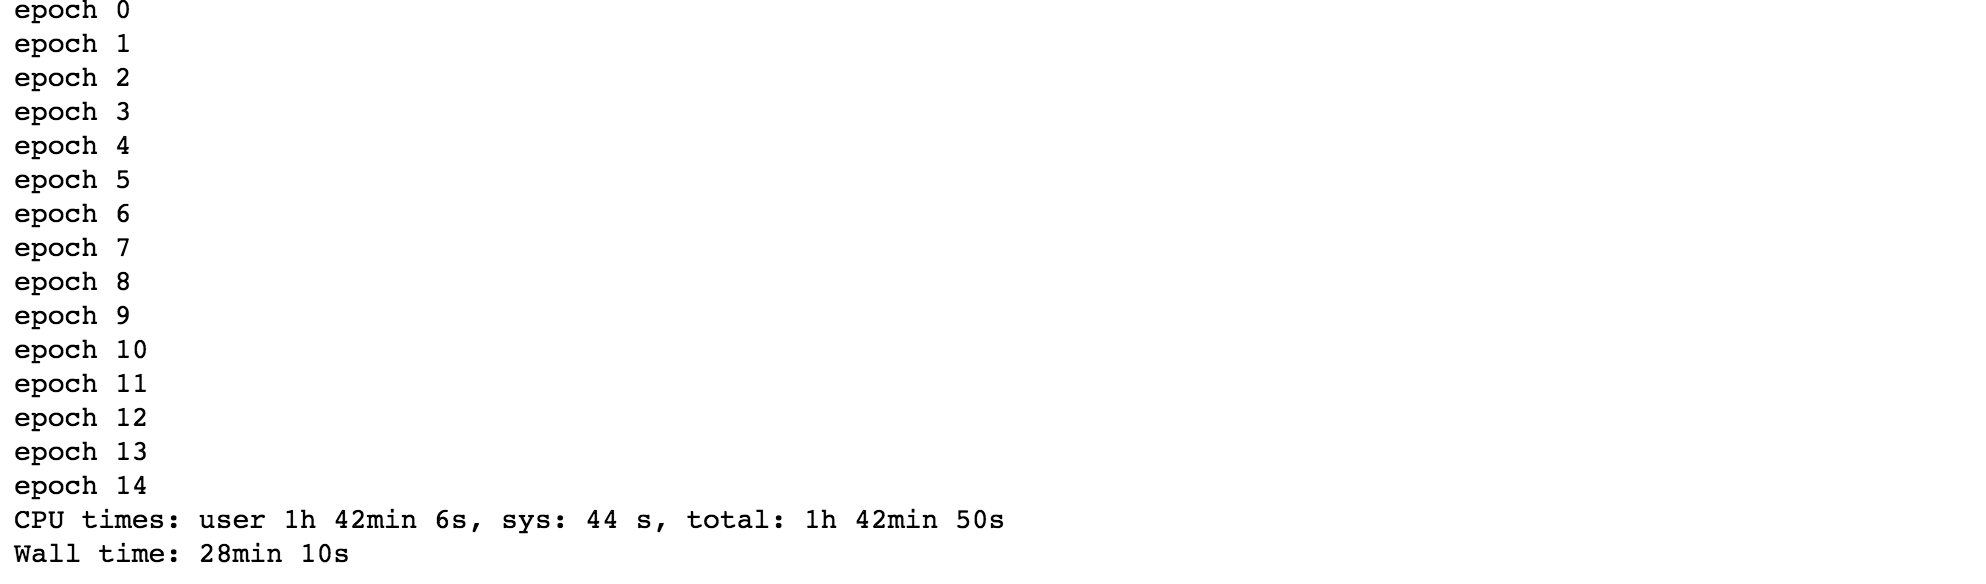

# HDBSCAN

HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

To find clusters we want to find the islands of higher density amid a sea of sparser noise -- and the assumption of noise is important: real data is messy and has outliers, corrupt data, and noise. The core of the clustering algorithm is single linkage clustering, and it can be quite sensitive to noise: a single noise data point in the wrong place can act as a bridge between islands, gluing them together. Obviously we want our algorithm to be robust against noise so we need to find a way to help 'lower the sea level' before running a single linkage algorithm.

In [9]:
def store_pickle(data, path):
    # store data in a pickle file
    with open(path, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


def load_pickle(path):
    # load data from a pickle file
    with open(path, 'rb') as f:
        return(pickle.load(f))

In [ ]:
# load vectors
d2v_model = gensim.models.doc2vec.Doc2Vec.load('./doc2vec_20170119_v7_processed_skip_gram_100d.model')
vectors = d2v_model.docvecs.doctag_syn0
print len(vectors)

In [ ]:
print vectors[1]

In [ ]:
sample = pd.DataFrame(vectors)

# take a sample of 100,000 vectors and put random_state to 42 for checking results on sample
s = sample.sample(100000, random_state=42)
s_label_index = sample.sample(100000, random_state=42).index
# convert back to format readable by HDBSCAN
s_array = s.as_matrix()

# hdbscan does not allow for cosine distance as metric so here i will use the l2 normalization instead in combination with euclidian distance
norm_data = normalize(s_array, norm='l2')


In [ ]:
%%time
# set prediction_data=True to generate extra cached data for predicting labels or membership vectors for new unseen points later.
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, prediction_data=True)
hdb = clusterer.fit(norm_data)
# save model
print "saving model..."
with open('/home/ubuntu/capstone/hdb_100k_skip_gram.pkl', 'wb') as f:
    pickle.dump(hdb, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# normalize whole vector array
norm_data = normalize(vectors, norm='l2')

# Use approximate_predict to cluster the whole data set. 
%%time
all_labels, strengths = hdbscan.approximate_predict(clusterer1, norm_data)
print "saving model..."
with open('/home/ubuntu/capstone/hdb_all_approx_predict_skip_gram_norm.pkl', 'wb') as f:
    pickle.dump(all_labels, f, protocol=pickle.HIGHEST_PROTOCOL)

# Also saving the probabilities for each comment/cluster
with open('/home/ubuntu/capstone/hdb_all_approx_predict_skip_gram_norm_prob.pkl', 'wb') as f:
    pickle.dump(strengths, f, protocol=pickle.HIGHEST_PROTOCOL)

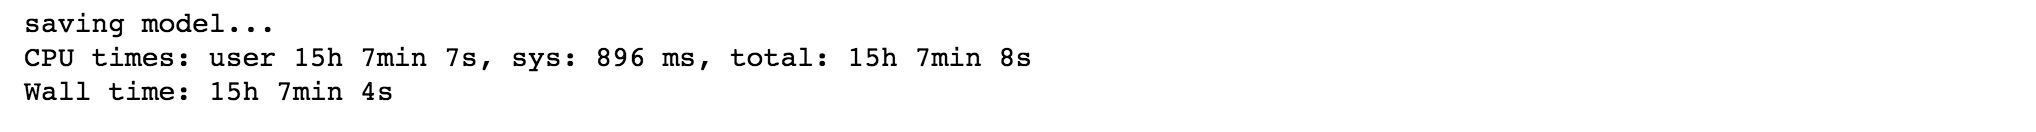

In [ ]:
hdb_100k_fit_skip_gram = load_pickle('./hdb_100k_skip_gram.pkl')

In [ ]:
# Create condensed tree plot visualising the density branches selected by hdbscan.

figxx = hdb_100k_fit_skip_gram.condensed_tree_.plot(select_clusters=True, selection_palette=None, log_size=True).get_figure()
figxx.set_size_inches(10.5, 18.5)
figxx.savefig("test_tree18.png")

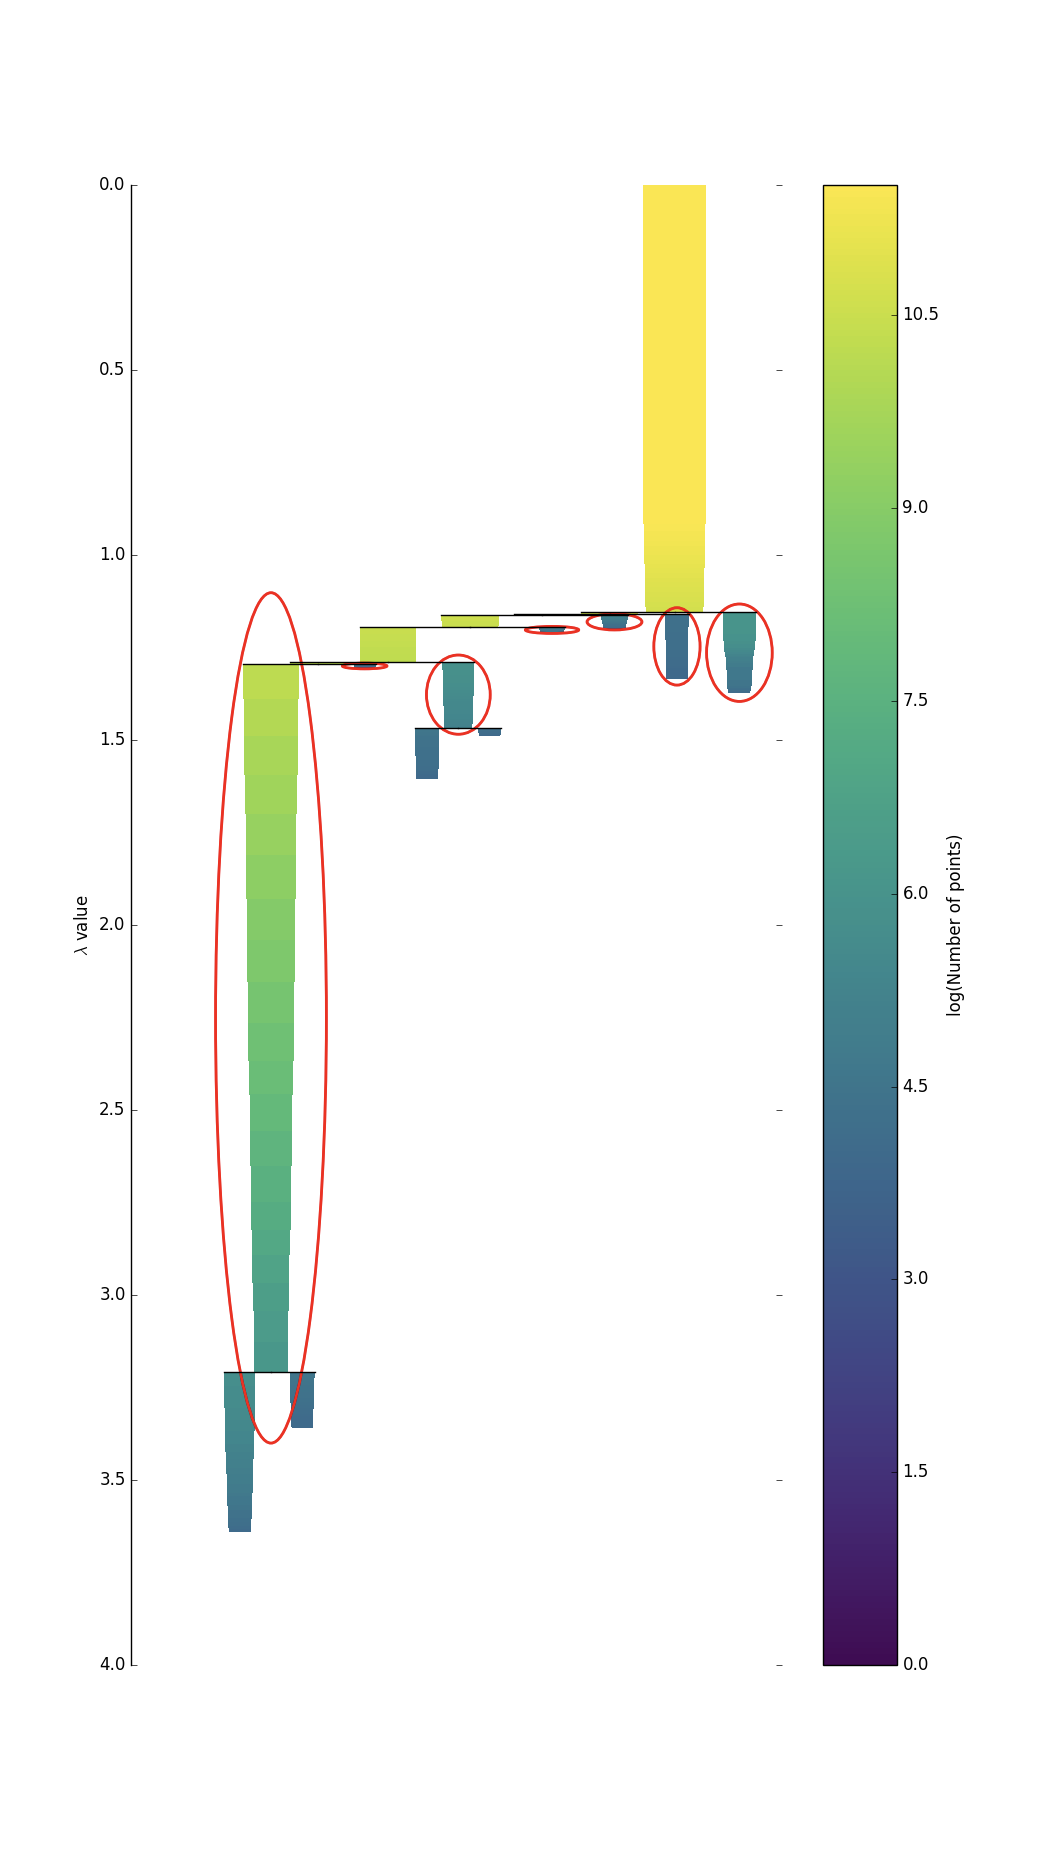

In this graph, HDBSCAN visualises the hierarchy of its selected clusters and the related cluster density. It selected 7 clusters in total with 3 clusters on the top hierarchical level. The more density a cluster has the more yellow it is. Cluster 5 is the largest cluster and could have been split into two further clusters.
 

In [4]:
hdbscan_results = pd.read_csv('./hdb_all_approx_predict_skip_gram_norm.csv', index_col=0)

In [5]:
# dropping all columns containing results from less sucessful clustering parameters
hdbscan_results.drop(['level_0_cluster','approx_predict_skip_gram_100d', 'hdb_all_approx_predict_skip_gram'], axis=1, inplace=True)

In [17]:
hdbscan_results

,dupe_count,text_data,hdb_all_approx_predict_skip_gram_norm,skip_gram_probabilities
57898,1.0,Getting rid of net neutrality will hurt small ...,-1,0.000000
57899,1.0,I’m calling on the FCC to stand up for net neu...,-1,0.000000
57900,1.0,Keep Net Neutrality! This is vital.,5,0.524763
57901,1.0,Are you guys kidding? Isn't this your jobs to ...,-1,0.000000
57902,1.0,The FCC needs to stand up for Internet users l...,-1,0.000000
57903,1.0,The internet is meant to be a safe haven for e...,-1,0.000000
57904,1.0,Net neutrality should be preserved in accordan...,-1,0.000000
57905,1.0,Freedom of Speach and Assembly should be fough...,-1,0.000000
57906,1.0,The internet should be open to everyone equall...,-1,0.000000
57907,1.0,the fact that an ISP in any shape or form can ...,-1,0.000000


In [7]:
# Cluster -1 are the comments HDBSCAN could not assign to any cluster - noise points
# Slightly less than 250k comments were assigned to clusters, most being bot generated
hdbscan_results.hdb_all_approx_predict_skip_gram_norm.value_counts()

-1    631774
 5    236547
 0      3863
 4      3062
 2      1213
 3      1107
 1       580
 6       549
Name: hdb_all_approx_predict_skip_gram_norm, dtype: int64

In [18]:
data = hdbscan_results.copy()

To further investigate, i want to check the average probability with which HDBSCAN has assigned a comment to a cluster

In [19]:
probabilities = load_pickle('./hdb_all_approx_predict_skip_gram_norm_prob.pkl')

In [20]:
hdbscan_results['skip_gram_probabilities'] = probabilities

In [24]:
# Obtaining the average probability per cluster.
cluster_6 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == 6][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster 6 mean comment probability:", cluster_6.skip_gram_probabilities.mean()

cluster_1 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == 1][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster 1 mean comment probability:", cluster_1.skip_gram_probabilities.mean()

cluster_3 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == 3][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster 3 mean comment probability:",cluster_3.skip_gram_probabilities.mean()

cluster_2 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == 2][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster 2 mean comment probability:",cluster_2.skip_gram_probabilities.mean()

cluster_4 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == 4][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster 4 mean comment probability:",cluster_4.skip_gram_probabilities.mean()

cluster_0 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == 0][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster 0 mean comment probability:",cluster_0.skip_gram_probabilities.mean()

cluster_5 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == 5][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster 5 mean comment probability:",cluster_5.skip_gram_probabilities.mean()

cluster_10 = data.loc[data.hdb_all_approx_predict_skip_gram_norm == -1][['text_data', 'hdb_all_approx_predict_skip_gram_norm','skip_gram_probabilities']]
print "cluster -1 mean comment probability:",cluster_10.skip_gram_probabilities.mean()

cluster 6 mean comment probability: 0.999455675826
cluster 1 mean comment probability: 0.981140812643
cluster 3 mean comment probability: 0.99695729877
cluster 2 mean comment probability: 0.987785499124
cluster 4 mean comment probability: 0.969474134734
cluster 0 mean comment probability: 0.926516564481
cluster 5 mean comment probability: 0.552032929207
cluster -1 mean comment probability: 0.0


When a comment is labeled with a probability of 1.0, it would mean that the comment is part of the clusters' core comments. Comments with a probability of less than 0.4 to any given cluster will not be clustered and marked as noise with a -1.

Cluster 3 seems to be the most homogenous with an average probability of 0.9969. 

In [ ]:
hdb_standard_config = load_pickle()

In [33]:
pd.options.display.max_colwidth = 500

Cluster 0


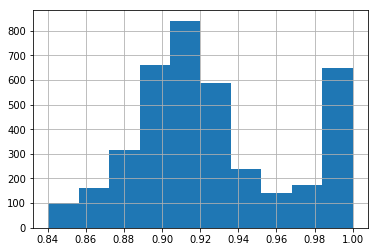

Cluster 1


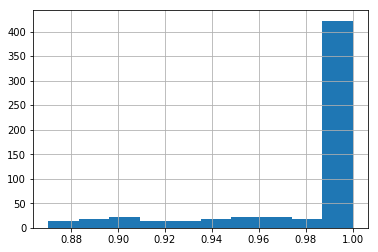

Cluster 2


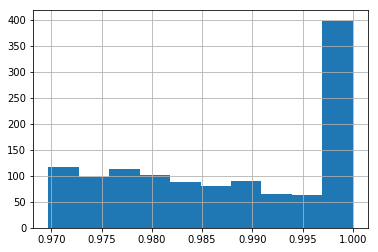

Cluster 3


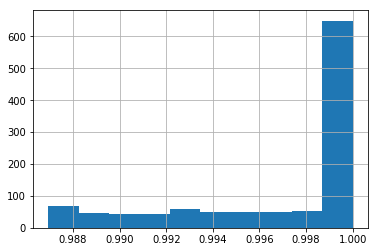

Cluster 4


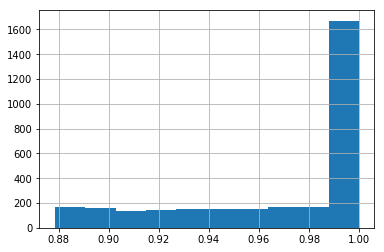

Cluster 5


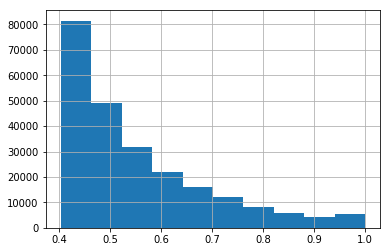

Cluster 6


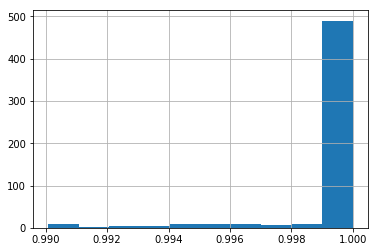

In [41]:
print "Cluster 0"
cluster_0.skip_gram_probabilities.hist()
plt.show()
print "Cluster 1"

cluster_1.skip_gram_probabilities.hist()
plt.show()
print "Cluster 2"

cluster_2.skip_gram_probabilities.hist()
plt.show()
print "Cluster 3"

cluster_3.skip_gram_probabilities.hist()
plt.show()
print "Cluster 4"

cluster_4.skip_gram_probabilities.hist()
plt.show()
print "Cluster 5"

cluster_5.skip_gram_probabilities.hist()
plt.show()
print "Cluster 6"

cluster_6.skip_gram_probabilities.hist()
plt.show()


In [57]:
# Check the probabilities for cluster 5
cluster_5.loc[cluster_5.skip_gram_probabilities < 0.9]

,text_data,hdb_all_approx_predict_skip_gram_norm,skip_gram_probabilities
57900,Keep Net Neutrality! This is vital.,5,0.524763
57909,INTERNET SHOULD BE OPEN AND FREE FROM CONTROL OF GREEDY ISPs,5,0.413998
57915,Preserve net neutrality and Title 2.\nI strongly support net neutrality backed by Title 2 oversight of ISP.,5,0.576007
57917,dont touch the internet,5,0.426711
57918,It is the right thing to do to keep net neutrality.,5,0.490324
57925,Save.,5,0.528079
57931,I DONT WANT COMCAST AND VERIZON TO CONTROL THE INTERNET,5,0.416350
57942,Keep the gosh darn internet free please!,5,0.427604
57945,Keep the internet freedom we deserve!,5,0.466338
57946,the internet is great man,5,0.416558


After going through Cluster 5 it would appear that it is not possible to confidently argue that comments with a probability of less than 1 are actually bot generated. 
Comments on the lower spectrum of the probability scale of Cluster 5 certainly seem to be human generated. HDBSCAN most likely clustered them with the bot comments due to the short and generic character of the comments.

Bot: "I specifically support strong Net Neutrality backed by TItle II oversight of ISP's" - probability = 1

Bot: "I strongly support strong net neutrality backed by Title II's oversight of ISPs" - probability = 1

Human: "I strongly support net neutrality and strong regulation of internet service providers. ISPs should be included in title two of the communications act and be held to title two's rules." - probability = 0.44

Human: "Stop slowing down my fucking internet you stupid cunts." - probability = 0.41

# Visualise Results

## Top 50 by Duplicate Count

The 50 most common comments account for nearly 50% of all submitted comments. 10,033,146 out of ~22 million. The bar chart below visualises the position of the comment - Is the comment for keeping title 2 and net neutrality in place or for repealing net neutrality and title 2

In [58]:
duplicates = pd.read_csv('./data_by_duplicates.csv', index_col=0)

/Users/johannesjanousek/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [65]:
pd.options.display.max_colwidth = 1000

In [69]:
# The top 50 comments by duplicate count split in keep and repeal title 2 net neutrality
repeal = [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 17, 19, 20, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 46, 48]
keep = [5, 9, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 41, 45, 47, 49]

In [71]:
# The top 50 comments by duplicate count
# duplicates.head(50)

In [72]:
top_50 = duplicates.head(50).copy()


,dupe_count,text_data
0,1096832.0,"In 2015, Chairman Tom Wheelers Federal Communications Commission (FCC) imposed restrictive Title II, utility-style regulations under the guise of an open internet. Not only have these regulations inhibited innovation in the internet ecosystem, they hurt taxpayers and consumers by expanding the regulatory reach of the FCC and limiting investment in internet infrastructure. We cannot allow this revolutionary tool to be bogged down with excessive government interference.\n \nIt is past time for the FCC, an agency that is funded by American taxpayers, to free the internet of burdensome regulations. By rolling back the misguided 2015 regulations we can restore an unrestricted and truly open internet. I thank the Commissioners for considering these comments during the reply period."
1,817622.0,"The unprecedented regulatory power the Obama Administration imposed on the internet is smothering innovation, damaging the American economy and obstructing job creation.\n\nI urge the Federal Communications Commission to end the bureaucratic regulatory overreach of the internet known as Title II and restore the bipartisan light-touch regulatory consensus that enabled the internet to flourish for more than 20 years.\n\nThe plan currently under consideration at the FCC to repeal Obama's Title II power grab is a positive step forward and will help to promote a truly free and open internet for everyone.\n"
2,550000.0,"The current FCC regulatory scheme known as ""Title II"" represents an unprecedented increase in government control over the internet. Such over-regulation is hurting our economy and suffocating innovation.\n \nI support Chairman Pai's plan to return to a commonsense regulatory framework that allows for the internet to grow without useless government interference. The internet has flourished for decades without the heavy hand of government over-regulation. Its time we return to what works."
3,545551.0,"Before leaving office, the Obama Administration rammed through a massive scheme that gave the federal government broad regulatory control over the internet. That misguided policy decision is threatening innovation and hurting broadband investment in one of the largest and most important sectors of the U.S. economy.\n \nI support the Federal Communications Commission's decision to roll back Title II and allow for free market principles to guide our digital economy."
4,468436.0,"The Obama-era FCC regulations known as ""Title II"" enable the federal government to exert an extraordinary and unnecessary amount of regulatory control over the internet. This bureaucratic overreach impedes innovation, stifles investment and continues to create economic uncertainty for one of the largest sectors of the U.S. economy.\n \nI support Chairman Pai's proposal to roll back Title II and restore the sensible regulatory framework that enjoyed broad bipartisan consensus and enabled the internet to thrive for more than two decades.\n \nI strongly urge all of the FCC Commissioners to support the Chairman's proposal to repeal the harmful Title II internet takeover.\n\n"
5,451706.0,"The FCC's Open Internet Rules (net neutrality rules) are extremely important to me. I urge you to protect them.\n\nI don't want ISPs to have the power to block websites, slow them down, give some sites an advantage over others, or split the Internet into ""fast lanes"" for companies that pay and ""slow lanes"" for the rest.\n\nNow is not the time to let giant ISPs censor what we see and do online.\n\nCensorship by ISPs is a serious problem. Comcast has throttled Netflix, AT&T blocked FaceTime, Time Warner Cable throttled the popular game League of Legends, and Verizon admitted it will introduce fast lanes for sites that pay-and slow lanes for everyone else-if the FCC lifts the rules. This hurts consumers and businesses large and small.\n\nCourts have made clear that if the FCC ends Title II classification, the FCC must let ISPs offer ""fast la

In [404]:
duplicates.dupe_count.sum()

22078910.0

In [75]:
for index in repeal:
    top_50.loc[index,'position'] = "repeal"
    
for index in keep:
    top_50.loc[index, 'position'] = "keep"

In [85]:
col_list = []
for pos in top_50.position:
    if pos == "repeal":
        col_list.append('red')
    else:
        col_list.append('blue')

In [140]:
y_labels = []
for text in top_50.text_data:
    y_labels.append(text[:20] + '..')

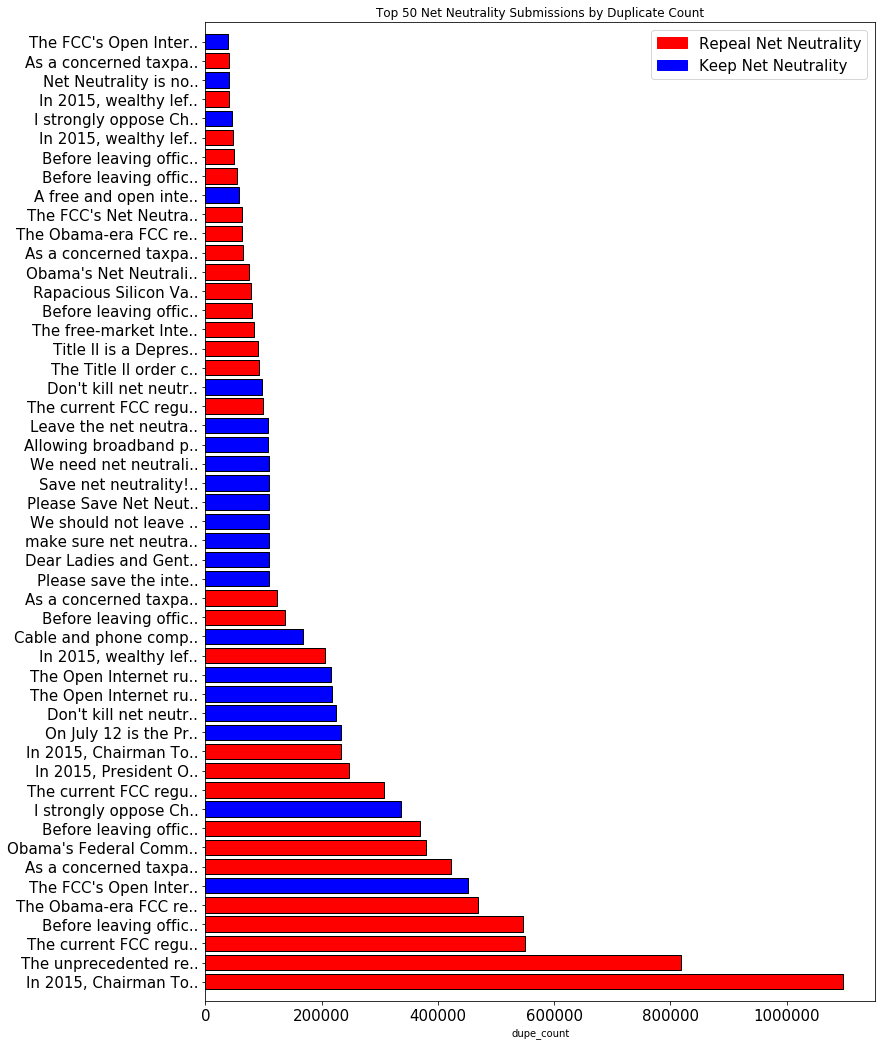

In [157]:
plt.figure(figsize=(12,18))
plt.barh(np.arange(50), top_50['dupe_count'], align='center', color=col_list,alpha=1.0, edgecolor='k',height=0.8)
plt.yticks(np.arange(50), y_labels,fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('dupe_count')
plt.ylim([-1,50])
plt.title('Top 50 Net Neutrality Submissions by Duplicate Count')

red_patch = mpatches.Patch(color='red', label='Repeal Net Neutrality')
blue_patch = mpatches.Patch(color='blue', label='Keep Net Neutrality')
plt.legend(handles=[red_patch,blue_patch],fontsize=15 )

plt.show()

In [151]:
# plt.clf()

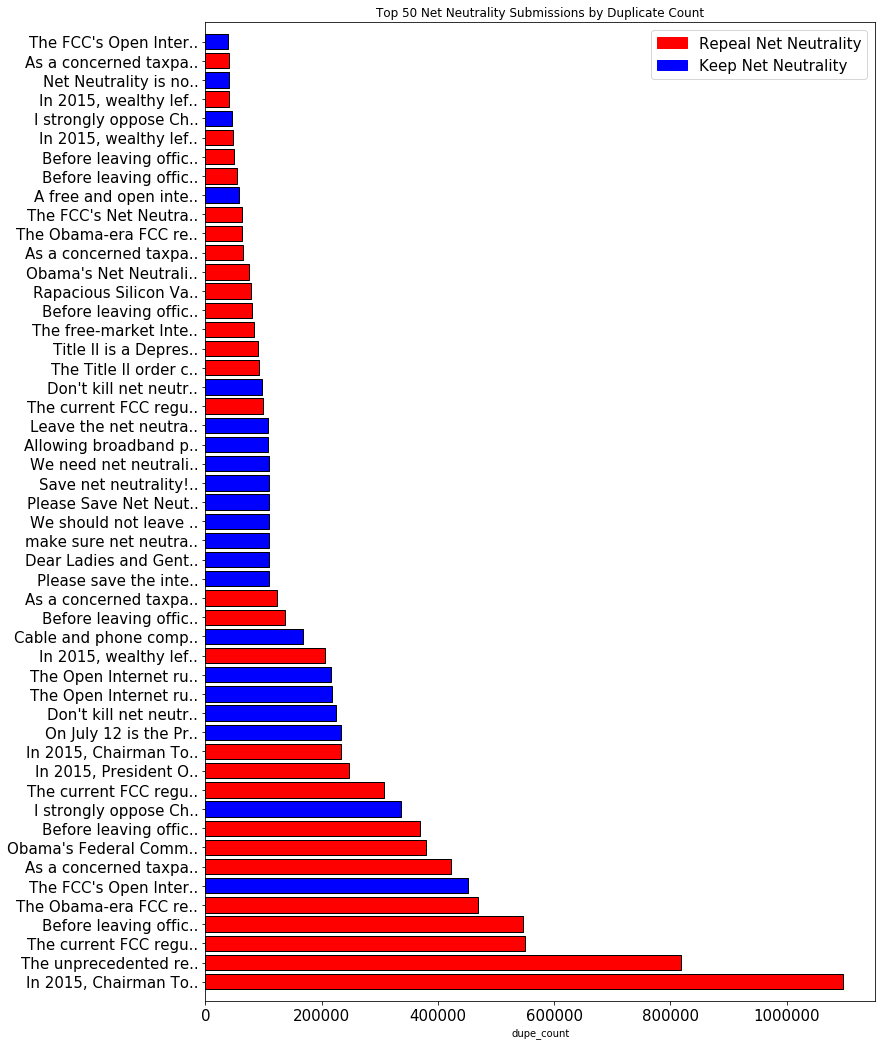

In [402]:
plt.figure(figsize=(12,18))
plt.barh(np.arange(50), top_50['dupe_count'], align='center', color=col_list,alpha=1.0, edgecolor='k',height=0.8)
plt.yticks(np.arange(50), y_labels,fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('dupe_count')
plt.ylim([-1,50])
plt.title('Top 50 Net Neutrality Submissions by Duplicate Count')

red_patch = mpatches.Patch(color='red', label='Repeal Net Neutrality')
blue_patch = mpatches.Patch(color='blue', label='Keep Net Neutrality')
plt.legend(handles=[red_patch,blue_patch],fontsize=15 )

# plt.show()

# figxx = hdb_100k_fit_skip_gram.condensed_tree_.plot(select_clusters=True, selection_palette=None, log_size=True).get_figure()
# figxx.set_size_inches(10.5, 18.5)
plt.savefig("top_50.png")



## Manually Clustered Bot Submissions

In [161]:
manual = pd.read_csv('./data_level_0_cluster.csv', index_col=0)

In [405]:
manual.level_0_cluster.value_counts().sum()

2018589L

In [163]:
# remove unclustered comments -1
manual = manual.loc[manual.level_0_cluster >-1]

In [400]:
manual.loc[manual.level_0_cluster ==14]

,text_data,level_0_cluster,position
dupe_count,,,
4.0,"FCC commissioners, I am a voter worried about Internet Freedom. I would like to request Ajit Pai to undo President Obama's policy to regulate broadband. Citizens, rather than so-called experts, should use whichever products we desire. President Obama's policy to regulate broadband is a corruption of net neutrality. It broke a free-market approach that performed very, very smoothly for a long time with nearly universal consensus.",14,repeal
2.0,"Dear Commissioners: I have thoughts on restoring Internet freedom. I suggest the commissioners to reverse Tom Wheeler's decision to control the web. People like me, not the FCC, ought to enjoy whichever products they desire. Tom Wheeler's decision to control the web is a corruption of the open Internet. It broke a market-based framework that worked exceptionally smoothly for many years with both parties' support.",14,repeal
2.0,"Dear Mr. Pai, I'm concerned about Title II rules. I want to ask Chairman Pai to overturn The Obama/Wheeler plan to regulate Internet access. Americans, as opposed to Washington bureaucrats, should enjoy whichever services we desire. The Obama/Wheeler plan to regulate Internet access is a perversion of the open Internet. It undid a pro-consumer policy that performed fabulously well for decades with broad bipartisan support.",14,repeal
2.0,"I am concerned about the FCC regulations on the Internet. I want to advocate you to repeal The Obama/Wheeler decision to take over Internet access. Individual citizens, as opposed to Washington bureaucrats, should be able to purchase whichever products they prefer. The Obama/Wheeler decision to take over Internet access is a distortion of net neutrality. It broke a hands-off policy that performed very, very successfully for many years with broad bipartisan backing.",14,repeal
2.0,"Dear Commissioners: I'm concerned about Network Neutrality. I advocate the commissioners to reverse Obama's scheme to take over Internet access. Internet users, not unelected bureaucrats, ought to purchase which applications they choose. Obama's scheme to take over Internet access is a corruption of net neutrality. It stopped a hands-off system that worked very, very smoothly for two decades with both parties' consensus.",14,repeal
2.0,"To the Federal Communications Commission: I would like to comment on Net neutrality. I suggest the Federal Communications Commission to overturn Barack Obama's scheme to take over the Internet. Individual citizens, as opposed to unelected bureaucrats, deserve to select whichever products we prefer. Barack Obama's scheme to take over the Internet is a exploitation of net neutrality. It reversed a free-market system that worked exceptionally well for a long time with both parties' approval.",14,repeal
2.0,"FCC commissioners, In reference to Internet Freedom. I want to request Ajit Pai to reverse President Obama's decision to regulate broadband. Individuals, as opposed to the FCC, should enjoy the products we desire. President Obama's decision to regulate broadband is a distortion of the open Internet. It reversed a market-based system that performed supremely successfully for a long time with bipartisan support.",14,repeal
2.0,"Mr Pai: My comments re: Internet regulation and net neutrality. I want to recommend the FCC to overturn Tom Wheeler's plan to control the Internet. Citizens, as opposed to the FCC Enforcement Bureau, deserve to buy whatever applications they want. Tom Wheeler's plan to control the Internet is a perversion of the open Internet. It disrupted a pro-consumer framework that performed exceptionally successfully for decades with both parties' approval.",14,repeal
2.0,"FCC: I'm contacting you about restoring Internet freedom. I'd like to request the commissioners to rescind Barack Obama's plan to control Internet access. Individual Americans, as opposed to unelected bureaucrats, should be free to select whatever applications we choose. Barack Obama's 

In [232]:
# I check the manually clustered comments for their position on net neutrality
mrepeal = [4.,14.]
mkeep = [0., 2., 3., 5., 6., 7., 9., 10., 11., 12., 13.]

In [223]:
manual.drop('position', axis=1, inplace=True)

In [227]:
manual['position'] = manual.level_0_cluster.map(lambda x: "keep" if x in mkeep else "repeal")

In [297]:
# save to csv for visualisation in tableau
manual.to_csv('/Users/johannesjanousek/Desktop/manualtableau.csv')

In [301]:
colorlist = map(lambda x: 'r' if x in mrepeal else 'b',sorted(mrepeal+mkeep))

In [359]:
counts = manual.level_0_cluster.value_counts()

In [360]:
colorlist = map(lambda x: 'r' if x in mrepeal else 'b',list(counts.index))

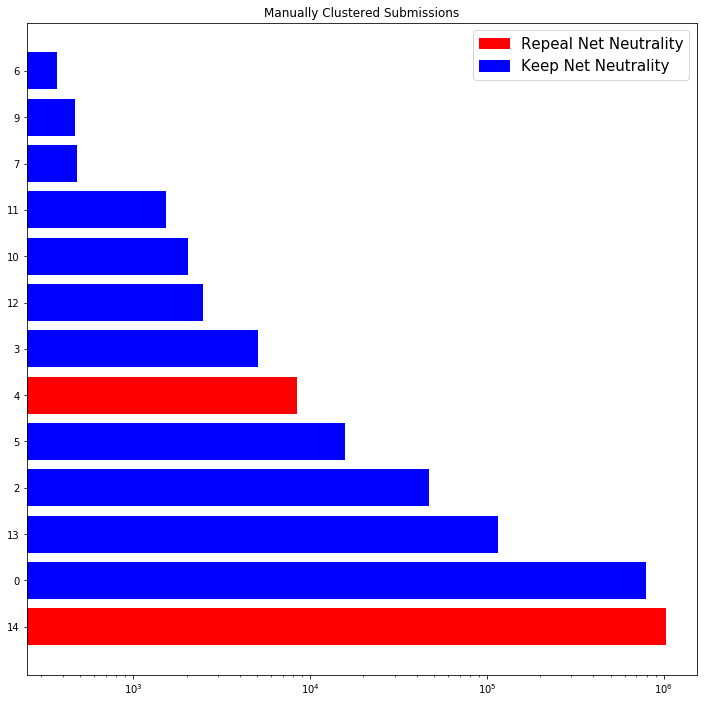

In [390]:
plt.figure(figsize=(12,12))
plt.barh(range(len(counts)),counts.values,color=colorlist)
plt.xscale('log')
plt.yticks(range(len(counts)),list(counts.index))

plt.title('Manually Clustered Submissions')

red_patch = mpatches.Patch(color='red', label='Repeal Net Neutrality')
blue_patch = mpatches.Patch(color='blue', label='Keep Net Neutrality')
plt.legend(handles=[red_patch,blue_patch],fontsize=15 )

plt.show()

I put the horizontal bar chart on a log scale as the value counts for the clusters 6, 7, 9, 11, 12 and 13 are to small in relation to cluster 0 and 14 to be effectively displayed

## HDBSCAN Cluster

In [369]:
hdb_cluster = pd.read_csv('./df_appr_pre_skip_100_norm_prob.csv', index_col=0)

In [408]:
hdb_cluster.hdb_all_approx_predict_skip_gram_norm.value_counts().sum()

631774L

In [373]:
# only keep the clustered comments
hdb_ = hdb_cluster.loc[hdb_cluster.hdb_all_approx_predict_skip_gram_norm > -1]

In [406]:
hdb_.hdb_all_approx_predict_skip_gram_norm.value_counts().sum()

246921L

In [383]:
hdb_.loc[hdb_.hdb_all_approx_predict_skip_gram_norm == 6]

,dupe_count,text_data,hdb_all_approx_predict_skip_gram_norm,skip_gram_probabilities
60141,1.0,"I’m worried that the protections that are in place will be weakened if we change the way they’re enforced. I would support a new regulation style if it guarantees the same or better protections, but not if we lose any. Paragraph 82 asks for input on whether throttling should be regulated. In the past ISPs have throttled content based on their own determination of what was lawful or permissible, and had to be forced to stop in the courts. Isn’t it possible they could do this again? I’m also concerned by mobile providers who say a plan is “unlimited,” but when you exceed the data cap, providers throttle sites and services that aren’t part of their approved zero-rating network. Thanks for reading my comment.",6,1.000000
61482,1.0,"Paragraph 82 asks for input on whether throttling should be regulated. In the past ISPs have throttled content based on their own determination of what was lawful or permissible, and had to be forced to stop in the courts. Isn’t it possible they could do this again? I’m also concerned by mobile providers who say a plan is “unlimited,” but when you exceed the data cap, only throttle sites and services that aren’t part of their approved zero-rating network. Thanks for reading my comment.\nAdditionally, I’m worried that the protections that are in place will be weakened if we change the way they’re enforced. I would support a new regulation style if it guarantees the same or better protections, but not if we lose any",6,1.000000
61760,1.0,"I’m worried that the protections that are in place will be weakened if we change the way they’re enforced. I would support a new regulation style only if it guarantees the same or better protections, but NOT if we lose any.\nParagraph 82 asks for input on whether throttling should be regulated. In the past ISPs have throttled content based on their own determination of what was lawful or permissible, and had to be forced to stop in the courts. Isn’t it possible they could do this again? I’m also concerned by mobile providers who say a plan is “unlimited,” but when you exceed the data cap, only throttle sites and services that aren’t part of their approved zero-rating network. Thanks for reading my comments.",6,1.000000
64740,1.0,"Net neutrality is vital to how people are able to use the internet in a fair way. I care about the open internet and competition online. In the past ISPs have throttled content based on their own determination of what was lawful or permissible, and had to be forced to stop in the courts. Isn’t it possible they could do this again? I’m also concerned by mobile providers who say a plan is “unlimited,” but when you exceed the data cap, only throttle sites and services that aren’t part of their approved zero-rating network. Thanks for reading my comment.",6,1.000000
69051,1.0,"ISPs have throttled content based on their own qualification of what was permissible, and had to be forced to stop in the courts in that past. They could do this again. Also concerning is mobile providers who say a plan is “unlimited,” but once you exceed the data cap, only throttle sites and services that aren’t part of their approved zero-rating network.",6,1.000000
69804,1.0,"I urge you to maintain Net Neutrality. Paragraph 82 asks for input on whether throttling should be regulated. In the past ISPs have throttled content based on their own determination of what was lawful or permissible, and had to be forced to stop in the courts. Isn’t it possible they could do this again? I’m also concerned by mobile providers who say a plan is “unlimited,” but when you exceed the data cap, only throttle sites and services that aren’t part of their approved zero-rating network. Thanks for reading my comment.",6,1.000000
70524,1.0,"Hello,\n\nNet neutrality and an open internet, safe from being throttled or controlled by corporations, is vital to the American way of life. I'm concerned about the

In [385]:
# After manually going through the clusters, it appears that all remaining clusters are for keeping title 2 net neutrality in place
hrepeal =[]
hkeep = [0, 1, 2, 3, 4, 5, 6]

In [387]:
hcounts = hdb_.hdb_all_approx_predict_skip_gram_norm.value_counts()

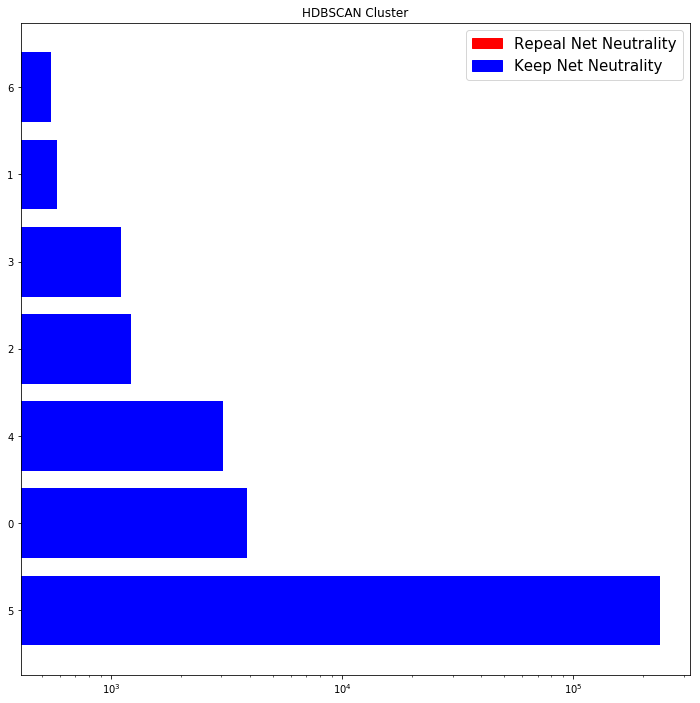

In [391]:
plt.figure(figsize=(12,12))
plt.barh(range(len(hcounts)),hcounts.values,color='b')
plt.xscale('log')
plt.yticks(range(len(hcounts)),list(hcounts.index))

plt.title('HDBSCAN Cluster')


red_patch = mpatches.Patch(color='red', label='Repeal Net Neutrality')
blue_patch = mpatches.Patch(color='blue', label='Keep Net Neutrality')
plt.legend(handles=[red_patch,blue_patch],fontsize=15 )

plt.show()

To get a more complete picture of the real public opinion i will read a random sample of 1000 comments from the remaining unclustered comments

In [392]:
sample = hdb_cluster.loc[hdb_cluster.hdb_all_approx_predict_skip_gram_norm == -1]

In [397]:
pd.options.display.max_rows = 1001

In [398]:
sample.sample(1000, random_state=32)

,dupe_count,text_data,hdb_all_approx_predict_skip_gram_norm,skip_gram_probabilities
452763,1.0,Ajit Pai represents the corporate interests of Verizon. If net neutrality is killed I will get rid of my Verizon shares and my Verizon communication services.\r\nMy elected officials will lose my support.,-1,0.0
261575,1.0,"The regulation around ISPs and the internet needs reform. \n\nRegardless of that reform being under Title 2 Classification or not is not the important issue.\n\nThe ONLY issue is that Net Neutrality should protected by a simply worded, but completely enforceable definition.\n\nISPs do not need over reaching regulation from the federal government beyond that.\n\nONLY enforce Net Neutrality. It's defintion is simple. Complicated red tag is not required, and it need not impede consumer choice.\n\nBut Net Neutrality itself is a modern right that all Americans need in order to have free speech protected on the internet.\n\nWhen you pay for the internet, you get the internet. America is one of the world leaders in the tech sector, and that has only happened because of the freedom to start a new business with ease with net neutrality.\n\nNetflix would have been crushed by throttling fees and data caps. \n\nYouTube was started by a pair of people who wrote a basic video player in flash. \...",-1,0.0
132002,1.0,"You have an enormous and amazing power to enable continued American internet innovation and dominance by maintaining net neutrality, which encouraged start ups in the past that became Amazon, Google, Facebook, and most recently Uber. Small companies won't have a chance if internet providers start to pick and choose (instead of the free market) by charging for access. I hope you will think of your legacy and make a decision that honors the proud history of the FCC and helps the majority of Americans now and in the future.",-1,0.0
185735,1.0,I care about keeping the open internet and encouraging competition online. \nKeep Net Neutrality,-1,0.0
835101,1.0,"Net Neutrality is incredibly important, let the current provisions stand, a rollback would be detrimental to small and medium sized businesses across the country",-1,0.0
139195,1.0,"The internet is too important and valuable to be throttled by special interests controlling how we use it. As our elected and appointed representatives of this country, YOU WORK FOR US, not the other way around. Americans are generally apathetic, But boy do we love our internet and we'll fight to keep it open and fair for everyone to use. So do the right thing, leave the internet alone.",-1,0.0
385000,1.0,"The FCC should ensure a fair and open Internet for all by opposing efforts to undermine net neutrality. \r\n\r\nThe FCC should throw out Chairman Ajit Pai’s proposal to give the telecom giants like Verizon, AT&T, and Comcast free rein to engage in data discrimination, stripping users of the meaningful access and privacy rules we demanded and so recently won. \r\n\r\nI’m afraid of a “pay-to-play” Internet where ISPs can charge more for certain websites because users will have fewer options and a less diverse Internet. Thankfully, the current net neutrality rules ensure that Internet providers can’t slow or block customers’ ability to see certain websites or create Internet “fast lanes” by charging websites and online services more money to reach customers faster. That’s exactly the right balance to make sure competition in the Internet space is fair and benefits consumers and small businesses as well as larger players. Chairman Pai’s proposal would help turn Internet providers into ...",-1,0.0
724046,1.0,"The internet should be treated as a utility, and with that in mind the companies that provide it are not the ones in need of additional freedom, because it is the individual users that are beholden to these massive corporations whose interest the government should be serving in protecting our access to free and fair communication. Additionally through reading of the ""Restoring Interne

__Out of this 1000 comment sample, only 4 comments were in favour of repealing the title 2 net neutrality rules. 99.6% of comments were pro net neutrality __